# Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import ast  # To safely parse the string representation of lists
from datetime import datetime, timedelta
from scipy.signal import cheby2, filtfilt
from scipy.interpolate import interp1d
from scipy.stats import skew, kurtosis, zscore

from config import ALL_MEASURES, SAMPLES4_FREQ800, SAMPLES8_FREQ1000, SAMPLES8_FREQ1600, SAMPLES16_FREQ1600

# Funções de ajuda

## Leitura do arquivo

In [2]:
def read_file(data_file):
    """Read the file."""
    # Read the data from the CSV file
    with open(data_file, 'r') as file:
        data = file.readlines()
    return data

def read_last_measure(data_file):
    """Read the last measure from the file."""
    # Read the data from the CSV file
    with open(data_file, 'r') as file:
        data = file.readlines()
    
    # Extract the last line (most recent data)
    last_line = data[-1].strip()  # Remove leading/trailing whitespace
    return last_line

def read_all_measures(data_file):
    """Read all measures from the file."""
    with open(data_file, 'r') as file:
        data = file.readlines()
    return [line.strip() for line in data]



## Parsing

In [3]:
def parse_measure(last_measure):
    """ Parse the line into components: timestamp, measure time, redSignal, and irSignal."""
    try:
        timestamp, measureTime, red_measure_str, ir_measure_str = last_measure.split(';')
        redMeasure = ast.literal_eval(red_measure_str)  # Convert the string representation of list to a list
        irMeasure = ast.literal_eval(ir_measure_str)    # Convert the string representation of list to a list
    except ValueError as e:
        print(f"Error parsing line: {last_line}")
        raise e

    # Convert both signals to numpy arrays for easier processing
    redSignal = np.array(redMeasure)
    irSignal = np.array(irMeasure)
    
    # Multiply both signals by -1 to invert them
    redSignal = -redSignal
    irSignal = -irSignal
    
    return timestamp, measureTime, redSignal, irSignal

def time_manager(timestamp, measureTime, irSignal):
    """ Manage Time elements, return datetime, measure time and measure frequency"""
    # Convert timestamp to datetime object (assuming it's in UTC)
    dt = datetime.utcfromtimestamp(int(timestamp))
    
    # Adjust for the time zone by subtracting 3 hours
    dt_adjusted = dt - timedelta(hours=3)
    
    # Format the datetime as day/month/year hour:minute:second
    formatted_datetime = dt_adjusted.strftime("%d/%m/%Y %H:%M:%S")
    
    # Adjust the measure time to seconds
    measureTime = int(measureTime)/1000

    # Calculate the frequency
    num_values = len(irSignal)
    measureFrequency = (num_values/measureTime)

    return formatted_datetime, measureTime, measureFrequency



## Filtering

In [4]:
def moving_average(signal, window_size):
    """Apply a moving average filter to the given signal."""
    return np.convolve(signal, np.ones(window_size) / window_size, mode='valid')

def compute_fft_in_db(signal, sampling_frequency):
    """Compute FFT, corresponding frequencies, and convert magnitude to dB."""
    N = len(signal)
    fft_values = np.fft.fft(signal)
    fft_magnitude = np.abs(fft_values[:N // 2])  # Only take the positive frequencies
    fft_magnitude_db = 20 * np.log10(fft_magnitude + 1e-10)  # Add small value to avoid log(0)
    freqs = np.fft.fftfreq(N, d=1 / sampling_frequency)[:N // 2]  # Corresponding frequencies
    return freqs, fft_magnitude_db

def chebyshev_bandpass_filter(signal, measure_time, lowcut=0.01, highcut=15.0, order=4, attenuation=40):
    """
    Apply a Chebyshev-II bandpass filter to a signal.
    
    Args:
        signal (array): Input signal to be filtered.
        measure_time (float): Duration of the signal in seconds.
        lowcut (float): Low cut frequency in Hz. Default is 0.5 Hz.
        highcut (float): High cut frequency in Hz. Default is 8.0 Hz.
        order (int): Order of the filter. Default is 4.
        attenuation (float): Stopband attenuation in dB. Default is 40 dB.
    
    Returns:
        filtered_signal (array): The filtered signal.
    """
    num_values = len(signal)
    fs = num_values / (measure_time / 1000)  # Sampling frequency (measure time is in ms)
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Design the Chebyshev-II filter
    b, a = cheby2(order, attenuation, [low, high], btype='bandpass')
    
    # Apply the filter
    filtered_signal = filtfilt(b, a, signal)
    
    return filtered_signal



## Quality Index

In [5]:
def preprocess_file(data_file, window_size):
    """
    Analyze all measures in the file.
    Processes signals, applies filters, and computes FFTs.
    
    Returns:
        results (list): A list of dictionaries containing processed data.
    """
    # Read all measures
    all_measures = read_all_measures(data_file)
    
    results = []  # To store processed data for each measure

    # Iterate over all measures
    for idx, measure in enumerate(all_measures):
        # Parse the measure
        timestamp, measureTime, redSignal, irSignal = parse_measure(measure)
        
        # Get the parsed datetime, measure time, and measure frequency
        formatted_datetime, measureTime, measureFrequency = time_manager(timestamp, measureTime, irSignal)
        
        # Apply moving average filter
        redSignal_mov_avg = moving_average(redSignal, window_size)
        irSignal_mov_avg = moving_average(irSignal, window_size)

        # Apply Chebyshev-II filter
        redSignal_cheby = chebyshev_bandpass_filter(redSignal, measureTime)
        irSignal_cheby = chebyshev_bandpass_filter(irSignal, measureTime)
        
        # Store results in a dictionary
        results.append({
            "index": idx + 1,
            "datetime": formatted_datetime,
            "frequency": measureFrequency,
            "measure_time": measureTime,
            "red_original": redSignal,
            "ir_original": irSignal,
            "red_mov_avg": redSignal_mov_avg,
            "ir_mov_avg": irSignal_mov_avg,
            "red_cheby": redSignal_cheby,
            "ir_cheby": irSignal_cheby
        })
    
    return results

def analyze_quality_indices(results):
    """
    Calculate skewness and kurtosis for each measure in the results.
    
    Args:
        results (list): List of dictionaries containing processed measures.

    Returns:
        dict: Dictionary containing mean skewness and kurtosis for all signals.
    """
    quality_indices = {
        "red_ori_skew": [], "ir_ori_skew": [],
        "red_ori_kurt": [], "ir_ori_kurt": [],
        "red_mov_skew": [], "ir_mov_skew": [],
        "red_mov_kurt": [], "ir_mov_kurt": [],
        "red_cheby_skew": [], "ir_cheby_skew": [],
        "red_cheby_kurt": [], "ir_cheby_kurt": []
    }

    for result in results:
        quality_indices["red_ori_skew"].append(skew(result["red_original"]))
        quality_indices["ir_ori_skew"].append(skew(result["ir_original"]))
        quality_indices["red_ori_kurt"].append(kurtosis(result["red_original"], fisher=True))
        quality_indices["ir_ori_kurt"].append(kurtosis(result["ir_original"], fisher=True))

        quality_indices["red_mov_skew"].append(skew(result["red_mov_avg"]))
        quality_indices["ir_mov_skew"].append(skew(result["ir_mov_avg"]))
        quality_indices["red_mov_kurt"].append(kurtosis(result["red_mov_avg"], fisher=True))
        quality_indices["ir_mov_kurt"].append(kurtosis(result["ir_mov_avg"], fisher=True))

        quality_indices["red_cheby_skew"].append(skew(result["red_cheby"]))
        quality_indices["ir_cheby_skew"].append(skew(result["ir_cheby"]))
        quality_indices["red_cheby_kurt"].append(kurtosis(result["red_cheby"], fisher=True))
        quality_indices["ir_cheby_kurt"].append(kurtosis(result["ir_cheby"], fisher=True))

    # Calculate mean values
    mean_quality_indices = {key: np.mean(values) for key, values in quality_indices.items()}
    return mean_quality_indices

def process_multiple_files(file_list, window_size):
    """
    Process multiple files and analyze their quality indices.
    
    Args:
        file_list (list): List of file paths to process.
        window_size (int): Window size for the moving average filter.
    
    Returns:
        dict: Aggregated results for all files.
    """
    all_file_results = {}

    for file_path in file_list:
        print(f"Processing file: {file_path}")
        results = preprocess_file(file_path, window_size)
        quality_indices = analyze_quality_indices(results)
        all_file_results[file_path] = quality_indices
    
    return all_file_results

## Plotting

In [6]:
def plot_original_movingAverage_red_ir(redSignal, irSignal, measureFrequency, formatted_datetime, filtered_time_axis, filtered_red_signal, filtered_ir_signal):
    # Create a figure with two subplots arranged side by side
    plt.figure(figsize=(12, 4))  # Adjust figure size as needed
    
    # Plot the original signals on the first subplot
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.plot(redSignal, label='Original Red Signal')
    plt.plot(irSignal, label='Original IR Signal')
    plt.plot([], label=f'Measure Frequency: {measureFrequency:.2f} Hz', color='white')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.title(f'Original Signals - {formatted_datetime}')
    plt.legend()
    plt.grid(True)
    
    # Plot the filtered signals on the second subplot
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.plot(filtered_time_axis, filtered_red_signal, label='Filtered Red Signal', linewidth=2)
    plt.plot(filtered_time_axis, filtered_ir_signal, label='Filtered IR Signal', linewidth=2)
    plt.plot([], label=f'Measure Frequency: {measureFrequency:.2f} Hz', color='white')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.title(f'Filtered Signals (Moving Average) - {formatted_datetime}')
    plt.legend()
    plt.grid(True)
    
    # Adjust layout to avoid overlapping elements
    plt.tight_layout()
    plt.show()

    return

def plot_preprocessed_file(results):
    """
    Plot the processed measures.
    
    Args:
        results (list): Processed data from the `analyze_measures` function.
    """
    # Prepare plots
    plt.figure(figsize=(12, 8))  # Adjust figure size as needed

    # Iterate over results to plot
    for result in results:
        idx = result["index"]
        
        # Plot original signals' spectra
        red_freqs, red_fft_db = result["red_original"]
        ir_freqs, ir_fft_db = result["ir_original"]
        filtered_red_freqs, filtered_red_fft_db = result["red_filtered"]
        filtered_ir_freqs, filtered_ir_fft_db = result["ir_filtered"]

        plt.subplot(2, 2, 1)
        plt.plot(red_freqs, red_fft_db, label=f'Red Signal {idx}')
        
        plt.subplot(2, 2, 2)
        plt.plot(ir_freqs, ir_fft_db, label=f'IR Signal {idx}')
        
        # Plot filtered signals' spectra
        plt.subplot(2, 2, 3)
        plt.plot(filtered_red_freqs, filtered_red_fft_db, label=f'Filtered Red {idx}')
        
        plt.subplot(2, 2, 4)
        plt.plot(filtered_ir_freqs, filtered_ir_fft_db, label=f'Filtered IR {idx}')
    
    # Customize plots
    plt.subplot(2, 2, 1)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.title('Original Red Signal Spectrum (Log Scale)')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.title('Original IR Signal Spectrum (Log Scale)')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.title('Filtered Red Signal Spectrum (Log Scale)')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.title('Filtered IR Signal Spectrum (Log Scale)')
    plt.grid(True)
    plt.legend()

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


# Teste Inicial do Sensor

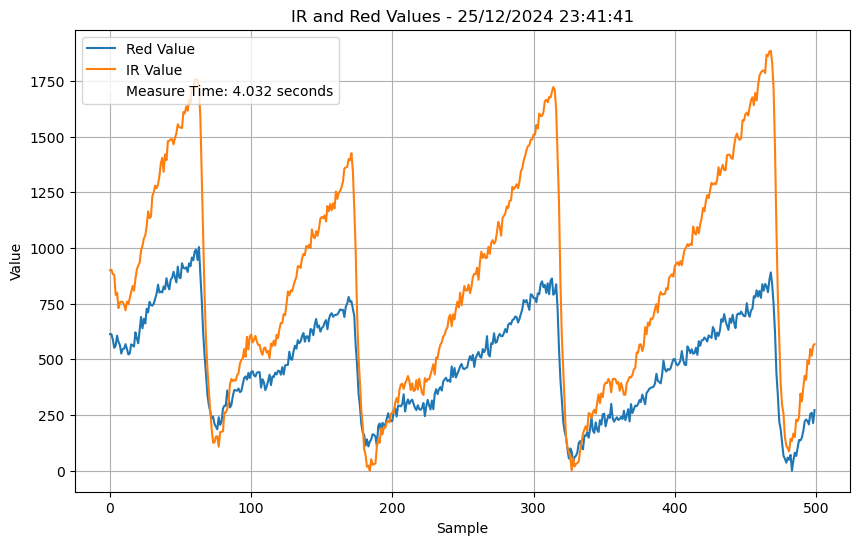

In [15]:
# Path to the CSV file
data_file = ALL_MEASURES

# Read the data from the CSV file
with open(data_file, 'r') as file:
    data = file.readlines()

# Extract the last line (most recent data)
last_line = data[-1].strip()  # Remove leading/trailing whitespace

# Parse the line into components: timestamp, redMeasure, and irMeasure
try:
    timestamp, measureTime, red_measure_str, ir_measure_str = last_line.split(';')
    redMeasure = ast.literal_eval(red_measure_str)  # Convert the string representation of list to a list
    irMeasure = ast.literal_eval(ir_measure_str)    # Convert the string representation of list to a list
except ValueError as e:
    print(f"Error parsing line: {last_line}")
    raise e

# Convert timestamp to datetime object (assuming it's in UTC)
dt = datetime.utcfromtimestamp(int(timestamp))

# Adjust for the time zone by subtracting 3 hours
dt_adjusted = dt - timedelta(hours=3)

# Format the datetime as day/month/year hour:minute:second
formatted_datetime = dt_adjusted.strftime("%d/%m/%Y %H:%M:%S")

# Adjust the measure time to seconds
measureTime = int(measureTime)/1000

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(redMeasure, label='Red Value')
plt.plot(irMeasure, label='IR Value')
plt.plot([], label=f'Measure Time: {measureTime} seconds', color='white')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title(f'IR and Red Values - {formatted_datetime}')
plt.legend()
plt.grid(True)

plt.show()


# Testes com diferentes parâmetros do sensor

Todos as combinações de parâmetros seguiram as diretrizes do datasheet:

| **Sample Rate (Hz)** | **Pulse Width** | **ADC Range (bits)** | **Expected Frequency (Hz)** | **Samples per Measure** |
|-----------------------|-----------------|-----------------------|-----------------------------|--------------------------|
| 800                   | 215             | 17                    | 200                         | 4                        |
| 1000                  | 118             | 16                    | 125                         | 8                        |
| 1600                  | 69              | 15                    | 200                         | 8                        |
| 1600                  | 69              | 15                    | 100                         | 16                      |
les

## 800 Hz / 4 amostras por medida

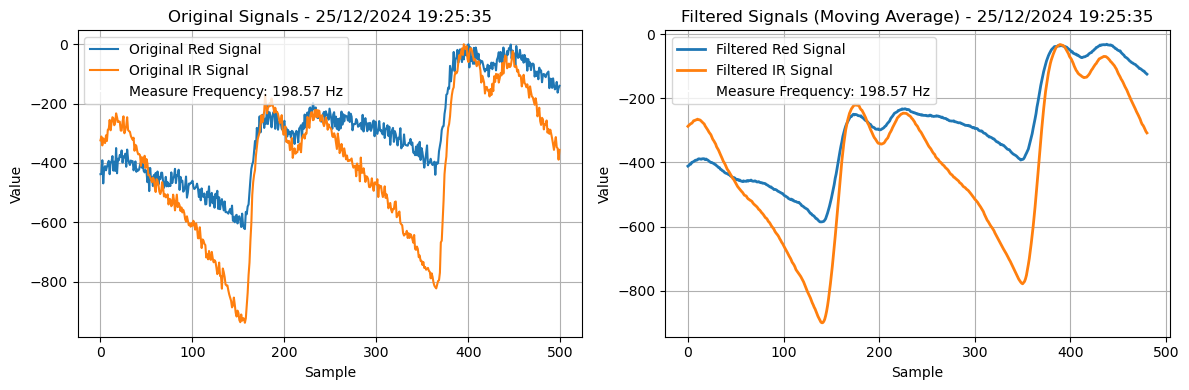

In [14]:
# Path to the CSV file
data_file = SAMPLES4_FREQ800

# Read the last signal from the file
last_measure = read_last_measure(data_file)

# Get the parsed features from the measure
timestamp, measureTime, redSignal, irSignal = parse_measure(last_measure)

# get the parsed datetime, measure time and measure frequency
formatted_datetime, measureTime, measureFrequency = time_manager(timestamp, measureTime, irSignal)

# Define the window size for the moving average filter
window_size = 20  # Adjust the size as needed for your data and smoothing level

# Apply the moving average filter to both signals
filtered_red_signal = moving_average(redSignal, window_size)
filtered_ir_signal = moving_average(irSignal, window_size)

# Adjust the time axis for the filtered signals
# Convolution with 'valid' reduces the length by (window_size - 1)
filtered_time_axis = np.arange(len(filtered_red_signal))

plot_original_movingAverage_red_ir(redSignal, irSignal, measureFrequency, formatted_datetime, filtered_time_axis, filtered_red_signal, filtered_ir_signal)

## 1000 Hz / 8 amostras por medida

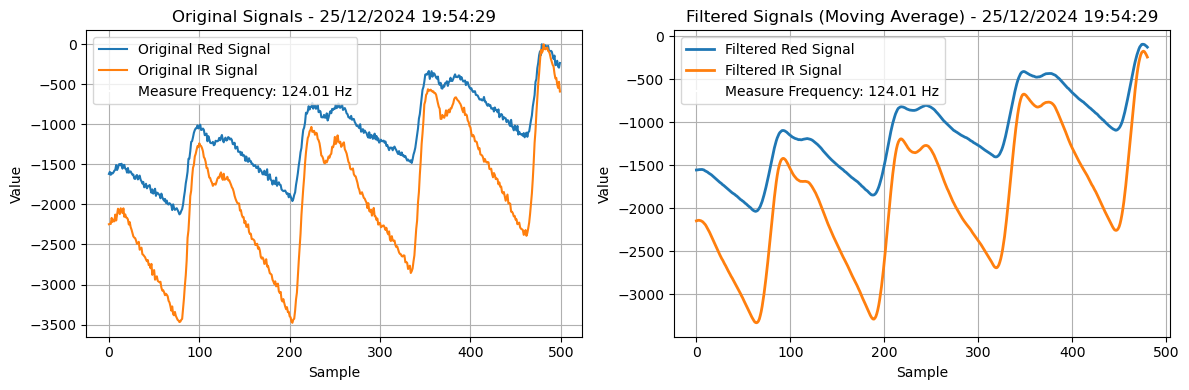

In [13]:
# Path to the CSV file
data_file = SAMPLES8_FREQ1000

# Read the last signal from the file
last_measure = read_last_measure(data_file)

# Get the parsed features from the measure
timestamp, measureTime, redSignal, irSignal = parse_measure(last_measure)

# get the parsed datetime, measure time and measure frequency
formatted_datetime, measureTime, measureFrequency = time_manager(timestamp, measureTime, irSignal)

# Define the window size for the moving average filter
window_size = 20  # Adjust the size as needed for your data and smoothing level

# Apply the moving average filter to both signals
filtered_red_signal = moving_average(redSignal, window_size)
filtered_ir_signal = moving_average(irSignal, window_size)

# Adjust the time axis for the filtered signals
# Convolution with 'valid' reduces the length by (window_size - 1)
filtered_time_axis = np.arange(len(filtered_red_signal))

plot_original_movingAverage_red_ir(redSignal, irSignal, measureFrequency, formatted_datetime, filtered_time_axis, filtered_red_signal, filtered_ir_signal)

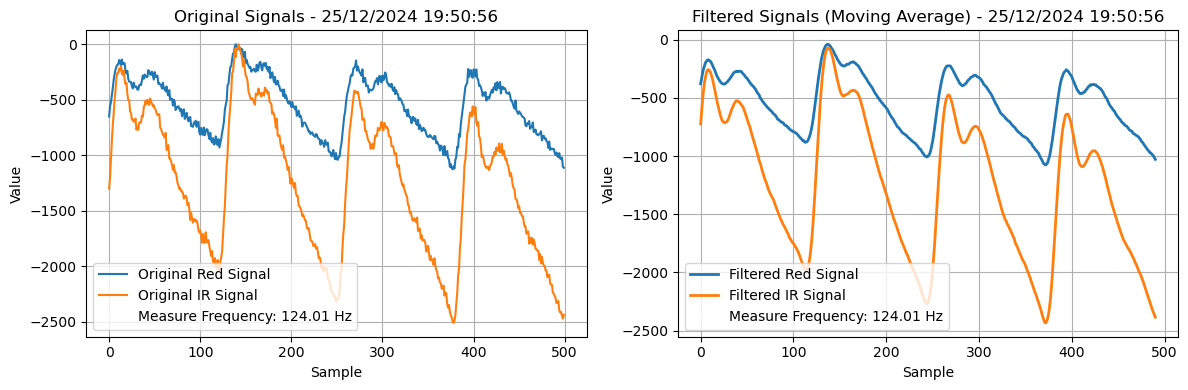

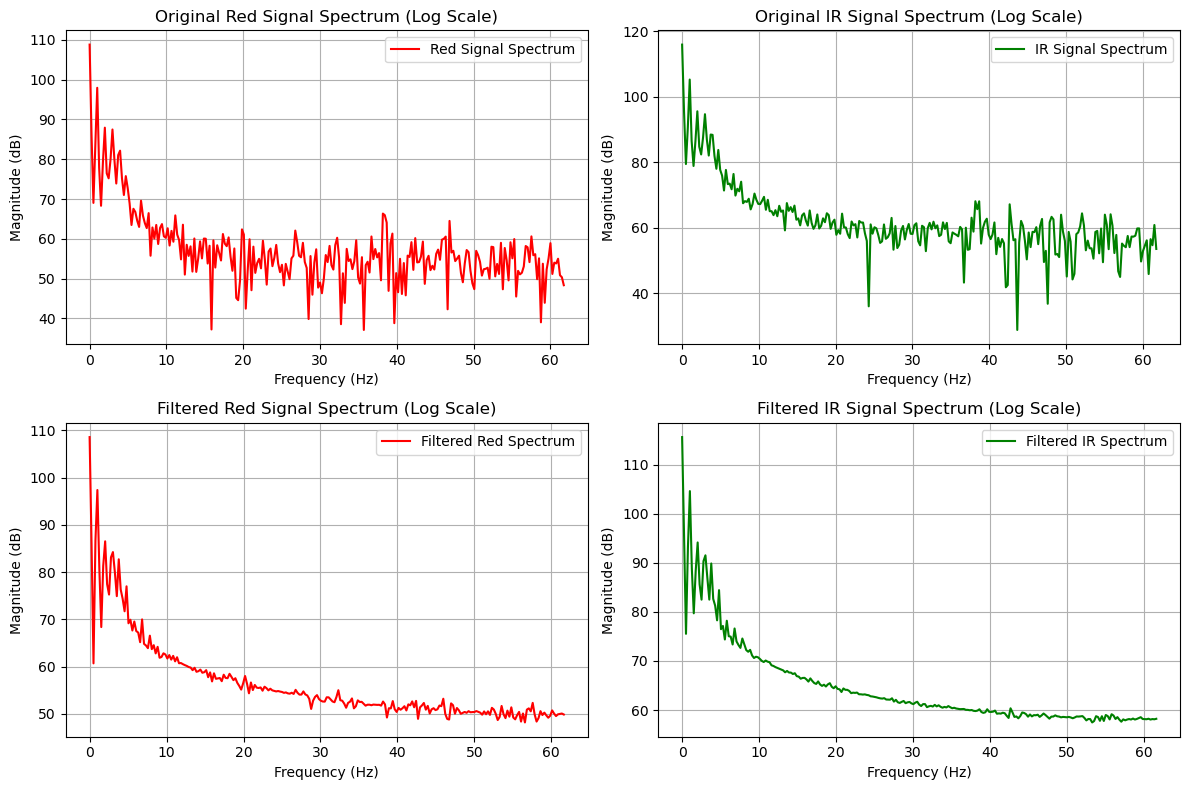

In [12]:
# Path to the CSV file
data_file = SAMPLES8_FREQ1000

# Read the file and choose measure
data = read_file(data_file)
measure = data[-8].strip()  # Remove leading/trailing whitespace

# Get the parsed features from the measure
timestamp, measureTime, redSignal, irSignal = parse_measure(measure)

# get the parsed datetime, measure time and measure frequency
formatted_datetime, measureTime, measureFrequency = time_manager(timestamp, measureTime, irSignal)

# Define the window size for the moving average filter
window_size = 10  # Adjust the size as needed for your data and smoothing level

# Apply the moving average filter to both signals
filtered_red_signal = moving_average(redSignal, window_size)
filtered_ir_signal = moving_average(irSignal, window_size)

# Adjust the time axis for the filtered signals
# Convolution with 'valid' reduces the length by (window_size - 1)
filtered_time_axis = np.arange(len(filtered_red_signal))

# Perform FFT on the original and filtered signals

# FFT for original signals
red_freqs, red_fft = compute_fft_in_db(redSignal, measureFrequency)
ir_freqs, ir_fft = compute_fft_in_db(irSignal, measureFrequency)

# FFT for filtered signals
filtered_red_freqs, filtered_red_fft = compute_fft_in_db(filtered_red_signal, measureFrequency)
filtered_ir_freqs, filtered_ir_fft = compute_fft_in_db(filtered_ir_signal, measureFrequency)

# FFT in dB for original signals
red_freqs, red_fft_db = compute_fft_in_db(redSignal, measureFrequency)
ir_freqs, ir_fft_db = compute_fft_in_db(irSignal, measureFrequency)

# FFT in dB for filtered signals
filtered_red_freqs, filtered_red_fft_db = compute_fft_in_db(filtered_red_signal, measureFrequency)
filtered_ir_freqs, filtered_ir_fft_db = compute_fft_in_db(filtered_ir_signal, measureFrequency)

plot_original_movingAverage_red_ir(redSignal, irSignal, measureFrequency, formatted_datetime, filtered_time_axis, filtered_red_signal, filtered_ir_signal)

# Plot the spectral analysis with logarithmic magnitude scale
plt.figure(figsize=(12, 8))  # Adjust figure size as needed

# Plot original signals' spectra
plt.subplot(2, 2, 1)
plt.plot(red_freqs, red_fft_db, label='Red Signal Spectrum', color='r')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Original Red Signal Spectrum (Log Scale)')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(ir_freqs, ir_fft_db, label='IR Signal Spectrum', color='g')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Original IR Signal Spectrum (Log Scale)')
plt.grid(True)
plt.legend()

# Plot filtered signals' spectra
plt.subplot(2, 2, 3)
plt.plot(filtered_red_freqs, filtered_red_fft_db, label='Filtered Red Spectrum', color='r')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Filtered Red Signal Spectrum (Log Scale)')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(filtered_ir_freqs, filtered_ir_fft_db, label='Filtered IR Spectrum', color='g')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Filtered IR Signal Spectrum (Log Scale)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## 1600 Hz / 8 amostras por medida

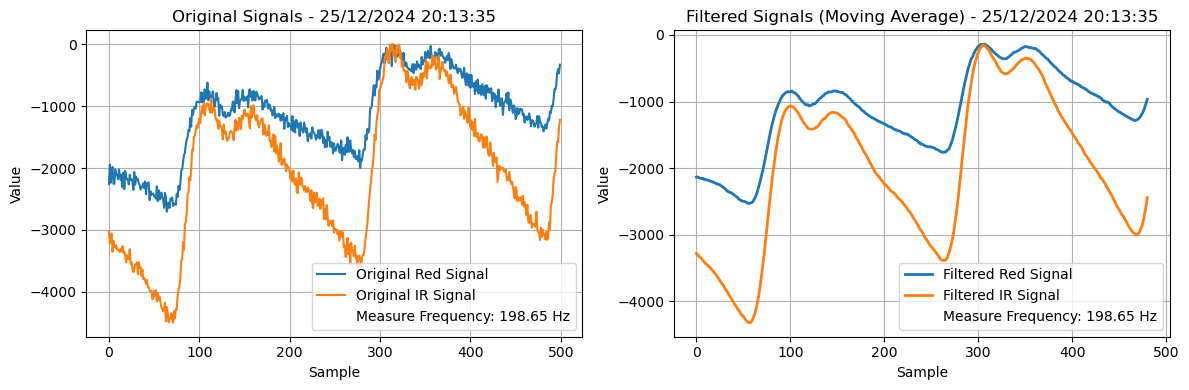

In [11]:
# Path to the CSV file
data_file = SAMPLES8_FREQ1600

# Read the last signal from the file
last_measure = read_last_measure(data_file)

# Get the parsed features from the measure
timestamp, measureTime, redSignal, irSignal = parse_measure(last_measure)

# get the parsed datetime, measure time and measure frequency
formatted_datetime, measureTime, measureFrequency = time_manager(timestamp, measureTime, irSignal)

# Define the window size for the moving average filter
window_size = 20  # Adjust the size as needed for your data and smoothing level

# Apply the moving average filter to both signals
filtered_red_signal = moving_average(redSignal, window_size)
filtered_ir_signal = moving_average(irSignal, window_size)

# Adjust the time axis for the filtered signals
# Convolution with 'valid' reduces the length by (window_size - 1)
filtered_time_axis = np.arange(len(filtered_red_signal))

plot_original_movingAverage_red_ir(redSignal, irSignal, measureFrequency, formatted_datetime, filtered_time_axis, filtered_red_signal, filtered_ir_signal)

## 1600 Hz / 16amostras por medida

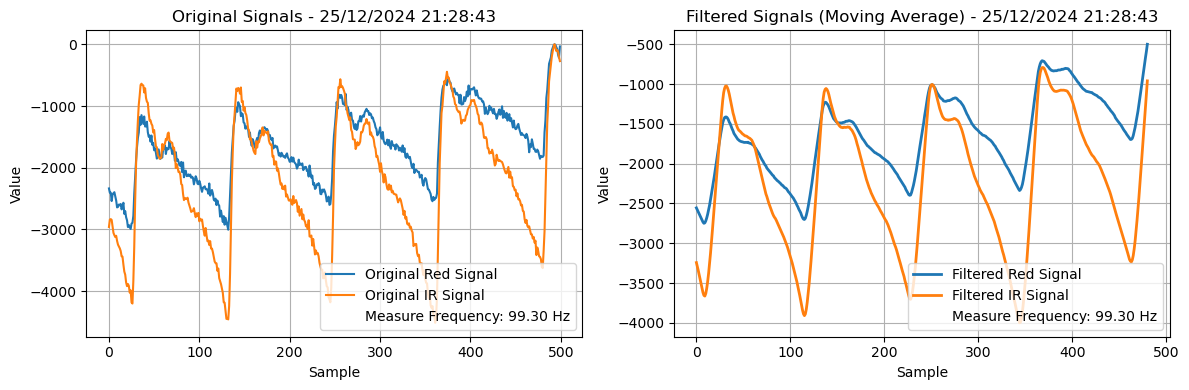

In [10]:
# Path to the CSV file
data_file = SAMPLES16_FREQ1600

# Read the last signal from the file
last_measure = read_last_measure(data_file)

# Get the parsed features from the measure
timestamp, measureTime, redSignal, irSignal = parse_measure(last_measure)

# get the parsed datetime, measure time and measure frequency
formatted_datetime, measureTime, measureFrequency = time_manager(timestamp, measureTime, irSignal)

# Define the window size for the moving average filter
window_size = 20  # Adjust the size as needed for your data and smoothing level

# Apply the moving average filter to both signals
filtered_red_signal = moving_average(redSignal, window_size)
filtered_ir_signal = moving_average(irSignal, window_size)

# Adjust the time axis for the filtered signals
# Convolution with 'valid' reduces the length by (window_size - 1)
filtered_time_axis = np.arange(len(filtered_red_signal))

plot_original_movingAverage_red_ir(redSignal, irSignal, measureFrequency, formatted_datetime, filtered_time_axis, filtered_red_signal, filtered_ir_signal)

# SQA - Signal Quality Assessment

## Definindo parâmetros do sensor

In [66]:
# Paths to the CSV files
data_file1 = SAMPLES4_FREQ800
data_file2 = SAMPLES8_FREQ1000
data_file3 = SAMPLES8_FREQ1600
data_file4 = SAMPLES16_FREQ1600

# Define the window size for the moving average filter
window_size = 10

# Setting the list of files to be analyzed
file_list = [SAMPLES4_FREQ800, SAMPLES8_FREQ1000, SAMPLES8_FREQ1600, SAMPLES16_FREQ1600]  # Replace with your file paths

# Calling the function that returns the analysis results
all_results = process_multiple_files(file_list, window_size)

# Display results
for file, indices in all_results.items():
    print(f"\nResults for {file}:")
    for key, value in indices.items():
        print(f"{key}: {value}")

Processing file: C:/Users/wgabr/TCC/CollectedData/800Hz_4samples.csv
Processing file: C:/Users/wgabr/TCC/CollectedData/1000Hz_8samples.csv
Processing file: C:/Users/wgabr/TCC/CollectedData/1600Hz_8samples.csv
Processing file: C:/Users/wgabr/TCC/CollectedData/1600Hz_16samples.csv

Results for C:/Users/wgabr/TCC/CollectedData/800Hz_4samples.csv:
red_ori_skew: -0.19216952558565506
ir_ori_skew: -0.2919933086721743
red_ori_kurt: -0.8641380728337733
ir_ori_kurt: -0.8632775362725867
red_mov_skew: -0.1826449833410143
ir_mov_skew: -0.28050666713931777
red_mov_kurt: -0.909396270968567
ir_mov_kurt: -0.8931326819923318
red_cheby_skew: 1.4686312588304946
ir_cheby_skew: 1.0504904185562665
red_cheby_kurt: 4.694118956205594
ir_cheby_kurt: 4.724103929089663

Results for C:/Users/wgabr/TCC/CollectedData/1000Hz_8samples.csv:
red_ori_skew: -0.09935092296351569
ir_ori_skew: -0.0785450320413821
red_ori_kurt: -0.8282710235307041
ir_ori_kurt: -0.8978453939728641
red_mov_skew: -0.11066693470396305
ir_mov_skew:

# Códigos Velhos

## Teste do Filtro proposto pelo artigo do Dataset PulseDB

Todos os sinais daqui para a frente estarão invertidos no eixo y

Red: Skewness -0.325057 ; Kurtosis -0.728046
IR: Skewness -0.377 ; Kurtosis -0.855


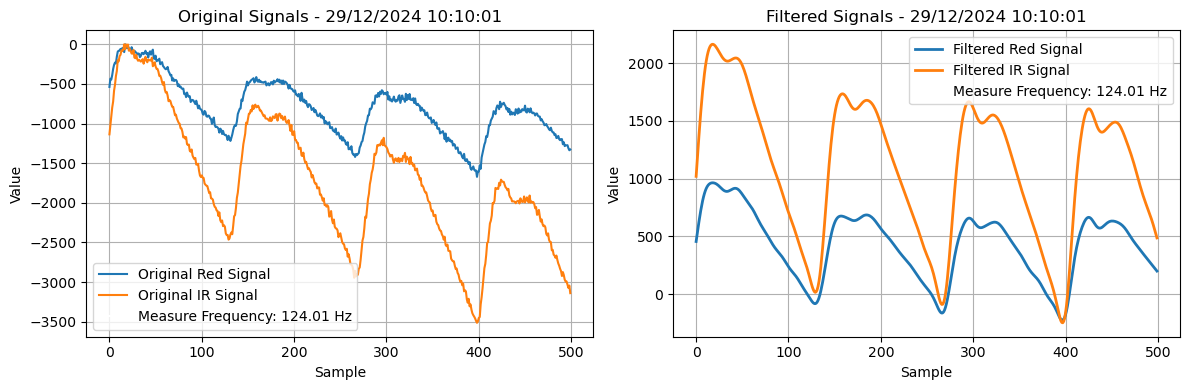

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import cheby2, filtfilt
import ast  # To safely parse the string representation of lists
from datetime import datetime, timedelta

# Path to the CSV file
data_file = 'C:/Users/wgabr/Jupyter Notebooks/TCC/CollectedData/red_ir_comparison.csv'

# Read the data from the CSV file
with open(data_file, 'r') as file:
    data = file.readlines()

# Extract the last line (most recent data)
last_line = data[-1].strip()  # Remove leading/trailing whitespace

# Parse the line into components: timestamp, redMeasure, and irMeasure
try:
    timestamp, measureTime, red_measure_str, ir_measure_str = last_line.split(';')
    redMeasure = ast.literal_eval(red_measure_str)  # Convert the string representation of list to a list
    irMeasure = ast.literal_eval(ir_measure_str)    # Convert the string representation of list to a list
except ValueError as e:
    print(f"Error parsing line: {last_line}")
    raise e

# Convert timestamp to datetime object (assuming it's in UTC)
dt = datetime.utcfromtimestamp(int(timestamp))

# Adjust for the time zone by subtracting 3 hours
dt_adjusted = dt - timedelta(hours=3)

# Format the datetime as day/month/year hour:minute:second
formatted_datetime = dt_adjusted.strftime("%d/%m/%Y %H:%M:%S")

# Adjust the measure time to seconds
measureTime = int(measureTime)/1000

# Convert both signals to numpy arrays for easier processing
red_signal = np.array(redMeasure)
ir_signal = np.array(irMeasure)

# Multiply both signals by -1 to invert them
red_signal = -red_signal
ir_signal = -ir_signal

# Design a 4th order Chebyshev-II bandpass filter
num_values = len(red_signal)  # Assuming both signals have the same length
fs = num_values / measureTime
lowcut = 0.01  # Low cut frequency in Hz
highcut = 15.0  # High cut frequency in Hz
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist

# Calculate the frequency
measureFrequency = (num_values/measureTime)

# Create the filter coefficients for the bandpass filter
b, a = cheby2(4, 40, [low, high], btype='bandpass')

# Apply the filter to both signals (Red and IR)
filtered_red_signal = filtfilt(b, a, red_signal)
filtered_ir_signal = filtfilt(b, a, ir_signal)

red_skew = skew(filtered_red_signal)
red_kurt = kurtosis(filtered_red_signal, fisher = True)
ir_skew = skew(filtered_ir_signal)
ir_kurt = kurtosis(filtered_ir_signal, fisher = True)
print(f"Red: Skewness {red_skew:3f} ; Kurtosis {red_kurt:3f}")
print(f"IR: Skewness {ir_skew:.3f} ; Kurtosis {ir_kurt:.3f}")

# Create a figure with two subplots arranged side by side
plt.figure(figsize=(12, 4))  # Adjust figure size as needed

# Plot the original signals on the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(red_signal, label='Original Red Signal')
plt.plot(ir_signal, label='Original IR Signal')
plt.plot([], label=f'Measure Frequency: {measureFrequency:.2f} Hz', color='white')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title(f'Original Signals - {formatted_datetime}')
plt.legend()
plt.grid(True)

# Plot the filtered signals on the second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(filtered_red_signal, label='Filtered Red Signal', linewidth=2)
plt.plot(filtered_ir_signal, label='Filtered IR Signal', linewidth=2)
plt.plot([], label=f'Measure Frequency: {measureFrequency:.2f} Hz', color='white')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title(f'Filtered Signals - {formatted_datetime}')
plt.legend()
plt.grid(True)

# Adjust layout to avoid overlapping elements
plt.tight_layout()
plt.show()

## Teste do Filtro proposto pelo artigo do Dataset com escala de 0 a 1

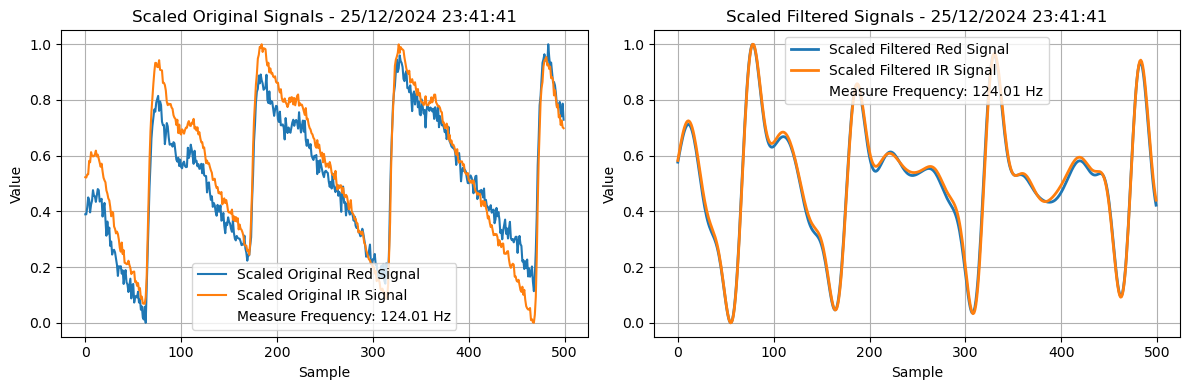

In [83]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import cheby2, filtfilt
import ast  # To safely parse the string representation of lists
from datetime import datetime, timedelta

# Path to the CSV file
data_file = 'C:/Users/wgabr/TCC/CollectedData/red_ir_comparison.csv'

# Read the data from the CSV file
with open(data_file, 'r') as file:
    data = file.readlines()

# Extract the last line (most recent data)
last_line = data[-1].strip()  # Remove leading/trailing whitespace

# Parse the line into components: timestamp, redMeasure, and irMeasure
try:
    timestamp, measureTime, red_measure_str, ir_measure_str = last_line.split(';')
    redMeasure = ast.literal_eval(red_measure_str)  # Convert the string representation of list to a list
    irMeasure = ast.literal_eval(ir_measure_str)    # Convert the string representation of list to a list
except ValueError as e:
    print(f"Error parsing line: {last_line}")
    raise e

# Convert timestamp to datetime object (assuming it's in UTC)
dt = datetime.utcfromtimestamp(int(timestamp))

# Adjust for the time zone by subtracting 3 hours
dt_adjusted = dt - timedelta(hours=3)

# Format the datetime as day/month/year hour:minute:second
formatted_datetime = dt_adjusted.strftime("%d/%m/%Y %H:%M:%S")

# Adjust the measure time to seconds
measureTime = int(measureTime)/1000

# Convert both signals to numpy arrays for easier processing
red_signal = np.array(redMeasure)
ir_signal = np.array(irMeasure)

# Multiply both signals by -1 to invert them
red_signal = -red_signal
ir_signal = -ir_signal

# 4th order Chebyshev-II bandpass filter
num_values = len(red_signal)
fs = num_values / measureTime
lowcut = 0.5
highcut = 8.0
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist

b, a = cheby2(4, 40, [low, high], btype='bandpass')

# Apply the filter to the PPG signal
red_filtered_signal = filtfilt(b, a, red_signal)
ir_filtered_signal = filtfilt(b, a, ir_signal)

# Scale the filtered signal between 0 and 1
red_scaled_signal = (red_signal - np.min(red_signal)) / (np.max(red_signal) - np.min(red_signal))
ir_scaled_signal = (ir_signal - np.min(ir_signal)) / (np.max(ir_signal) - np.min(ir_signal))
red_scaled_filtered_signal = (red_filtered_signal - np.min(red_filtered_signal)) / (np.max(red_filtered_signal) - np.min(red_filtered_signal))
ir_scaled_filtered_signal = (ir_filtered_signal - np.min(ir_filtered_signal)) / (np.max(ir_filtered_signal) - np.min(ir_filtered_signal))

# Create a figure with two subplots arranged side by side
plt.figure(figsize=(12, 4))  # Adjust figure size as needed

# Plot the original signals on the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(red_scaled_signal, label='Scaled Original Red Signal')
plt.plot(ir_scaled_signal, label='Scaled Original IR Signal')
plt.plot([], label=f'Measure Frequency: {measureFrequency:.2f} Hz', color='white')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title(f'Scaled Original Signals - {formatted_datetime}')
plt.legend()
plt.grid(True)

# Plot the filtered signals on the second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(red_scaled_filtered_signal, label='Scaled Filtered Red Signal', linewidth=2)
plt.plot(ir_scaled_filtered_signal, label='Scaled Filtered IR Signal', linewidth=2)
plt.plot([], label=f'Measure Frequency: {measureFrequency:.2f} Hz', color='white')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title(f"Scaled Filtered Signals - {formatted_datetime}")
plt.legend()
plt.grid(True)

# Adjust layout to avoid overlapping elements
plt.tight_layout()
plt.show()


## Teste Média Móvel

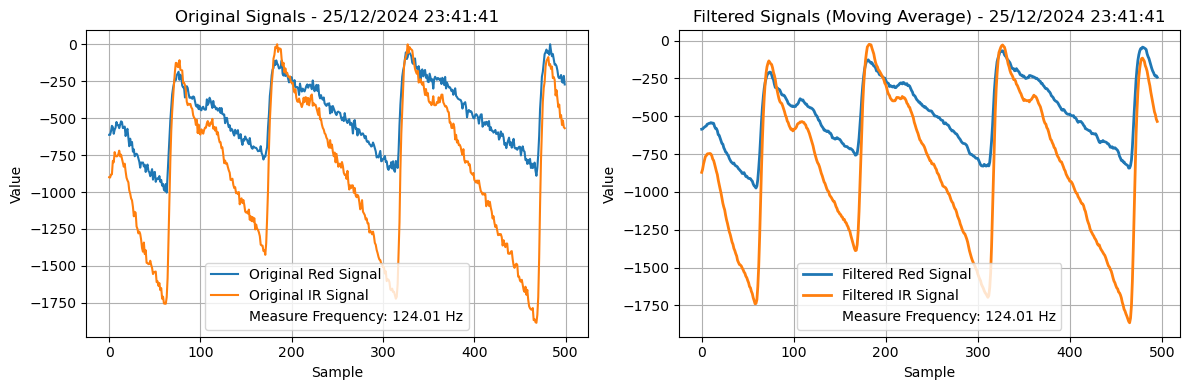

In [194]:
# Path to the CSV file
data_file = 'C:/Users/wgabr/TCC/CollectedData/red_ir_comparison.csv'

# Read the last signal from the file
last_measure = read_last_measure(data_file)

# Get the parsed features from the measure
timestamp, measureTime, redSignal, irSignal = parse_measure(last_measure)

# get the parsed datetime, measure time and measure frequency
formatted_datetime, measureTime, measureFrequency = time_manager(timestamp, measureTime, irSignal)

# Define the window size for the moving average filter
window_size = 5  # Adjust the size as needed for your data and smoothing level

# Apply the moving average filter to both signals
filtered_red_signal = moving_average(redSignal, window_size)
filtered_ir_signal = moving_average(irSignal, window_size)

# Adjust the time axis for the filtered signals
# Convolution with 'valid' reduces the length by (window_size - 1)
filtered_time_axis = np.arange(len(filtered_red_signal))

plot_original_movingAverage_red_ir(redSignal, irSignal, measureFrequency, formatted_datetime, filtered_time_axis, filtered_red_signal, filtered_ir_signal)

## Test

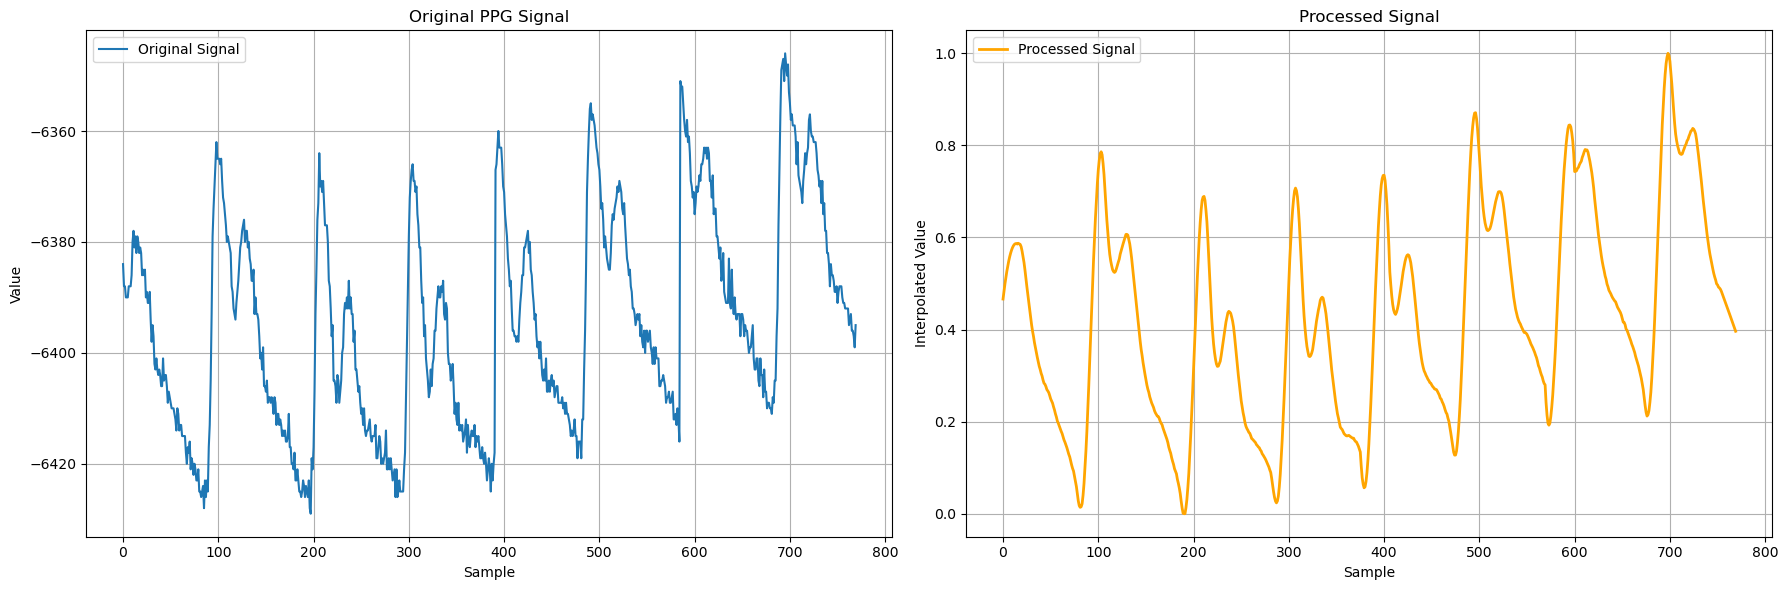

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import cheby2, filtfilt, savgol_filter
from scipy.interpolate import interp1d

# Read the data from the .txt file
data_file = 'sensor_data.txt'
with open(data_file, 'r') as file:
    data = file.readlines()

# Extract values from each line
values = []
for line_num, line in enumerate(data, start=1):
    line = line.strip()
    if line:  # This check ensures that the line is not empty
        try:
            value = int(line)
            values.append(value)
        except ValueError:
            print(f"Error parsing line {line_num}: {line}")

# Convert values to a numpy array
ppg_signal = np.array(values)* -1


"""
# 4th order Chebyshev-II bandpass filter
num_values = len(ppg_signal)
fs = num_values / 4
lowcut = 0.5
highcut = 8.0
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist

b, a = cheby2(4, 40, [low, high], btype='bandpass')

# Apply the filter to the PPG signal
filtered_signal = filtfilt(b, a, ppg_signal)

# Scale the filtered signal between 0 and 1
scaled_signal = (filtered_signal - np.min(filtered_signal)) / (np.max(filtered_signal) - np.min(filtered_signal))
"""

#"""
# Apply the Savitzky-Golay filter to the PPG signal
# window_length must be less than or equal to num_values and should be odd
# polyorder is the order of the polynomial used to fit the samples
window_length = 31  # Adjust as needed
polyorder = 2  # Adjust as needed

filtered_signal = savgol_filter(ppg_signal, window_length, polyorder)

# Scale the filtered signal between 0 and 1
scaled_signal = (filtered_signal - np.min(filtered_signal)) / (np.max(filtered_signal) - np.min(filtered_signal))

# Prepare the data for the model
scaled_signal = np.array(scaled_signal, dtype=np.float32)
#"""


# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Original signal
ax1.plot(ppg_signal, label='Original Signal')
ax1.set_xlabel('Sample')
ax1.set_ylabel('Value')
ax1.set_title('Original PPG Signal')
ax1.legend()
ax1.grid(True)
#ax1.set_ylim(19500, 21000)

# Processed Signal
ax2.plot(scaled_signal, label='Processed Signal', linewidth=2, color='orange')
ax2.set_xlabel('Sample')
ax2.set_ylabel('Interpolated Value')
ax2.set_title(f'Processed Signal')
ax2.legend()
ax2.grid(True)

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()

## Skewness SQI Test

Skewness Signal Quality Index (SSQI) Filtered: 1.0442652493156137
Skewness Signal Quality Index (SSQI) Original: 0.46634274029872863


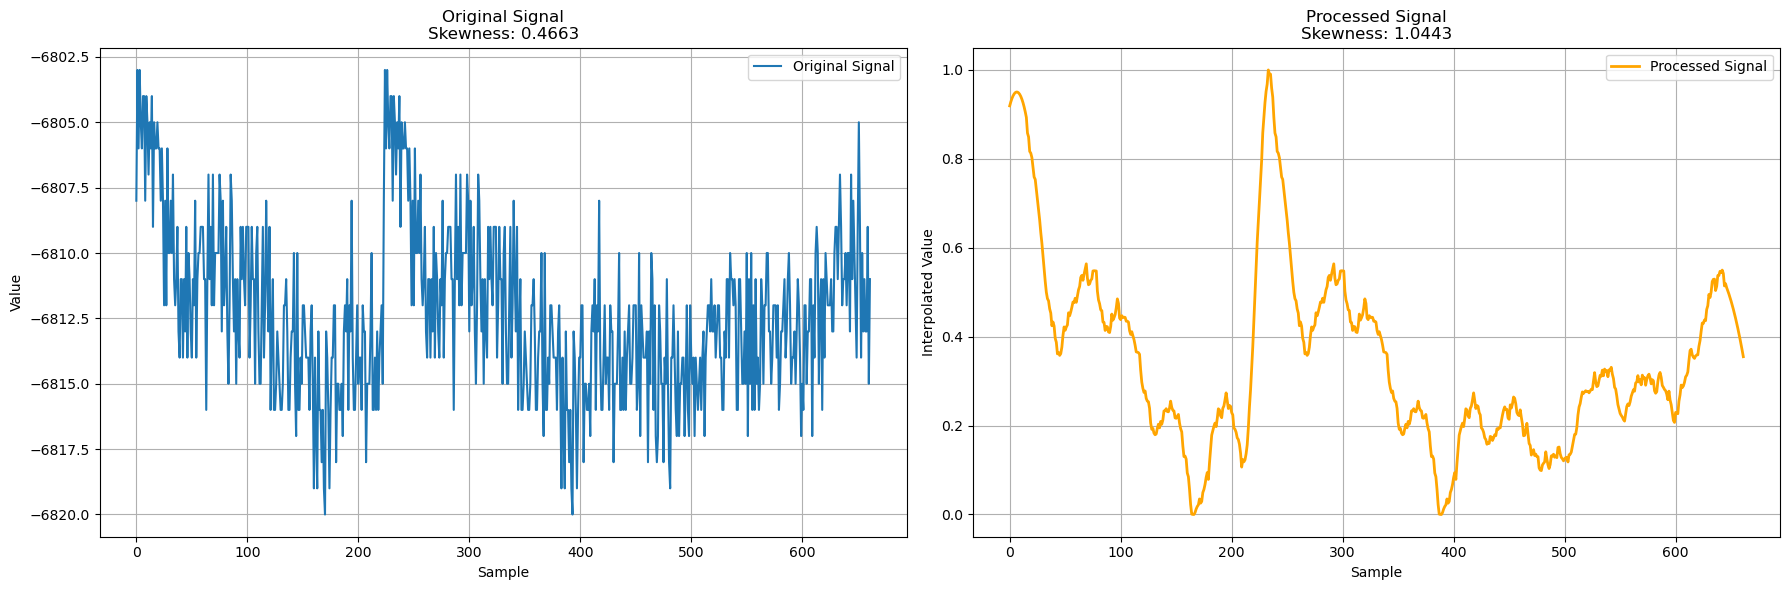

In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import cheby2, filtfilt, savgol_filter
from scipy.interpolate import interp1d
from scipy.stats import skew

# Read the data from the .txt file
data_file = 'sensor_data.txt'
with open(data_file, 'r') as file:
    data = file.readlines()

# Extract values from each line
values = []
for line_num, line in enumerate(data, start=1):
    line = line.strip()
    if line:  # This check ensures that the line is not empty
        try:
            value = int(line)
            values.append(value)
        except ValueError:
            print(f"Error parsing line {line_num}: {line}")

# Convert values to a numpy array
ppg_signal = np.array(values)* -1

""""
# Apply the Savitzky-Golay filter to the PPG signal
# window_length must be less than or equal to num_values and should be odd
# polyorder is the order of the polynomial used to fit the samples
window_length = 31  # Adjust as needed
polyorder = 2  # Adjust as needed

filtered_signal = savgol_filter(ppg_signal, window_length, polyorder)
""""

# 4th order Chebyshev-II bandpass filter
num_values = len(ppg_signal)
fs = num_values / 4
lowcut = 0.5
highcut = 8.0
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist

b, a = cheby2(4, 40, [low, high], btype='bandpass')

# Apply the filter to the PPG signal
filtered_signal = filtfilt(b, a, ppg_signal)

# Scale the filtered signal between 0 and 1
scaled_signal = (filtered_signal - np.min(filtered_signal)) / (np.max(filtered_signal) - np.min(filtered_signal))

# Prepare the data for the model
scaled_signal = np.array(scaled_signal, dtype=np.float32)

# Calculate skewness
ssqi_original = skew(ppg_signal)
ssqi_filtered = skew(scaled_signal)

# Print skewness
print(f'Skewness Signal Quality Index (SSQI) Filtered: {ssqi_filtered}')
print(f'Skewness Signal Quality Index (SSQI) Original: {ssqi_original}')

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Original signal
ax1.plot(ppg_signal, label='Original Signal')
ax1.set_xlabel('Sample')
ax1.set_ylabel('Value')
ax1.set_title(f'Original Signal\nSkewness: {ssqi_original:.4f}')
ax1.legend()
ax1.grid(True)

# Processed Signal
ax2.plot(scaled_signal, label='Processed Signal', linewidth=2, color='orange')
ax2.set_xlabel('Sample')
ax2.set_ylabel('Interpolated Value')
ax2.set_title(f'Processed Signal\nSkewness: {ssqi_filtered:.4f}')
ax2.legend()
ax2.grid(True)

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()

621
Datetime: 2024-08-19T21:27:30.869Z
Skewness Signal Quality Index (SSQI) Filtered: -0.2301360055446394
Skewness Signal Quality Index (SSQI) Original: -0.1610213144256207


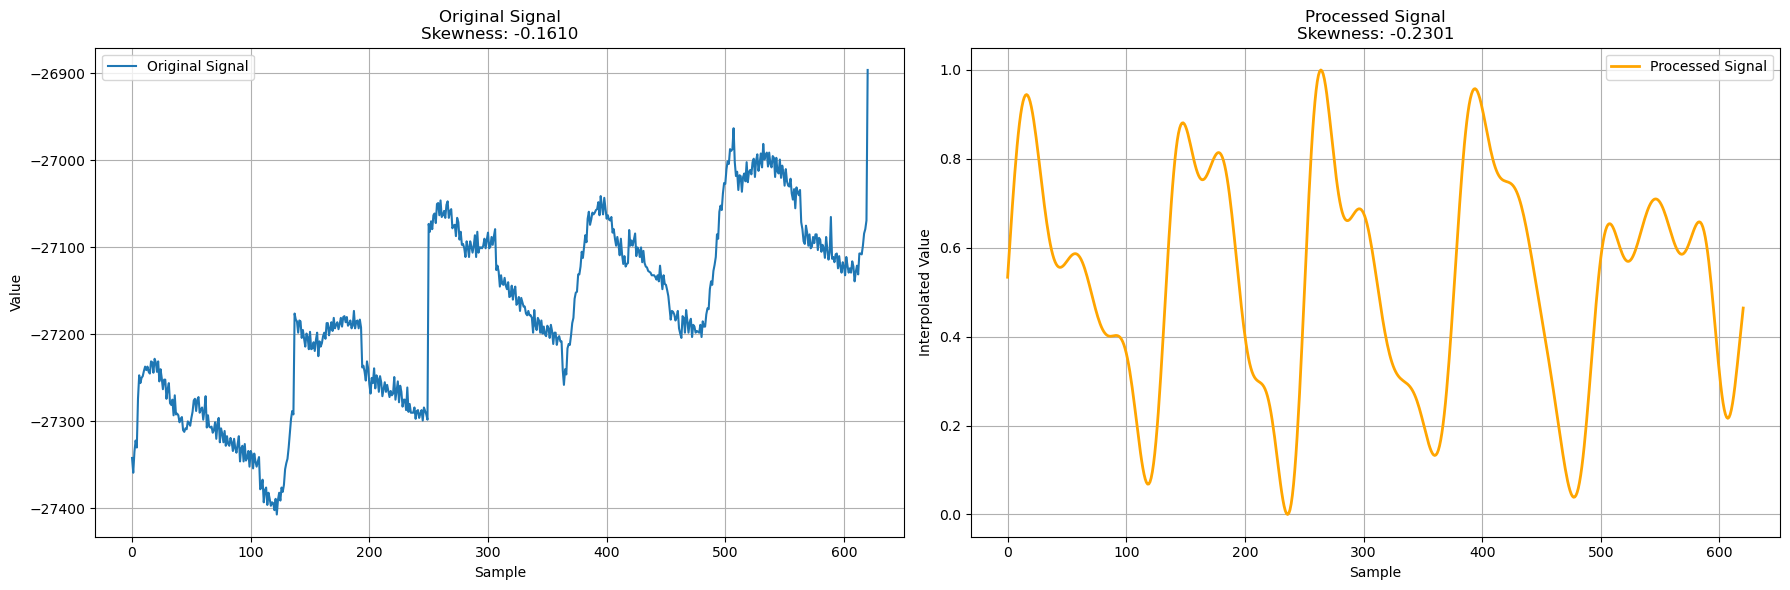

In [79]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter, cheby2,filtfilt
from scipy.stats import skew

# Read the data from the CSV file
data_file = 'C:/Users/wgabr/Python Codes/SmartBP/Computing/measures.csv'
df = pd.read_csv(data_file)

# Function to process and plot a specific measure by index
def process_and_plot_measure(index):
    # Extract the datetime and values string
    datetime = df.iloc[index, 0]
    values_string = df.iloc[index, 1].strip('"')

    # Convert the values string to a list of integers, handling any empty or invalid values
    try:
        values = [int(v) for v in values_string.split(',') if v.strip().isdigit()]
    except ValueError as e:
        print(f"Error parsing values on row {index + 1}: {e}")
        return

    # Convert values to a numpy array and apply any necessary transformations
    ppg_signal = np.array(values) * -1
    print(len(ppg_signal))

    """
    # Apply the Savitzky-Golay filter to the PPG signal
    window_length = 31  # Adjust as needed
    polyorder = 2  # Adjust as needed
    filtered_signal = savgol_filter(ppg_signal, window_length, polyorder)

    # Scale the filtered signal between 0 and 1
    scaled_signal = (filtered_signal - np.min(filtered_signal)) / (np.max(filtered_signal) - np.min(filtered_signal))
    """

    # 4th order Chebyshev-II bandpass filter
    num_values = len(ppg_signal)
    fs = num_values / 4
    lowcut = 0.5
    highcut = 8.0
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    
    b, a = cheby2(4, 40, [low, high], btype='bandpass')
    
    # Apply the filter to the PPG signal
    filtered_signal = filtfilt(b, a, ppg_signal)
    
    # Scale the filtered signal between 0 and 1
    scaled_signal = (filtered_signal - np.min(filtered_signal)) / (np.max(filtered_signal) - np.min(filtered_signal))
    
    # Prepare the data for the model
    scaled_signal = np.array(scaled_signal, dtype=np.float32)

    # Calculate skewness
    ssqi_original = skew(ppg_signal)
    ssqi_filtered = skew(scaled_signal)

    # Print skewness
    print(f'Datetime: {datetime}')
    print(f'Skewness Signal Quality Index (SSQI) Filtered: {ssqi_filtered}')
    print(f'Skewness Signal Quality Index (SSQI) Original: {ssqi_original}')

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Original signal
    ax1.plot(ppg_signal, label='Original Signal')
    ax1.set_xlabel('Sample')
    ax1.set_ylabel('Value')
    ax1.set_title(f'Original Signal\nSkewness: {ssqi_original:.4f}')
    ax1.legend()
    ax1.grid(True)

    # Processed Signal
    ax2.plot(scaled_signal, label='Processed Signal', linewidth=2, color='orange')
    ax2.set_xlabel('Sample')
    ax2.set_ylabel('Interpolated Value')
    ax2.set_title(f'Processed Signal\nSkewness: {ssqi_filtered:.4f}')
    ax2.legend()
    ax2.grid(True)

    # Adjust the spacing between subplots
    plt.tight_layout()
    plt.show()

# Example usage: process and plot the measure at index 0
process_and_plot_measure(-1)

400
Datetime: 2024-09-05T09:59:16.048Z
Skewness Signal Quality Index (SSQI) Filtered: 0.8602363643543105
Skewness Signal Quality Index (SSQI) Original: 0.6901732159896712


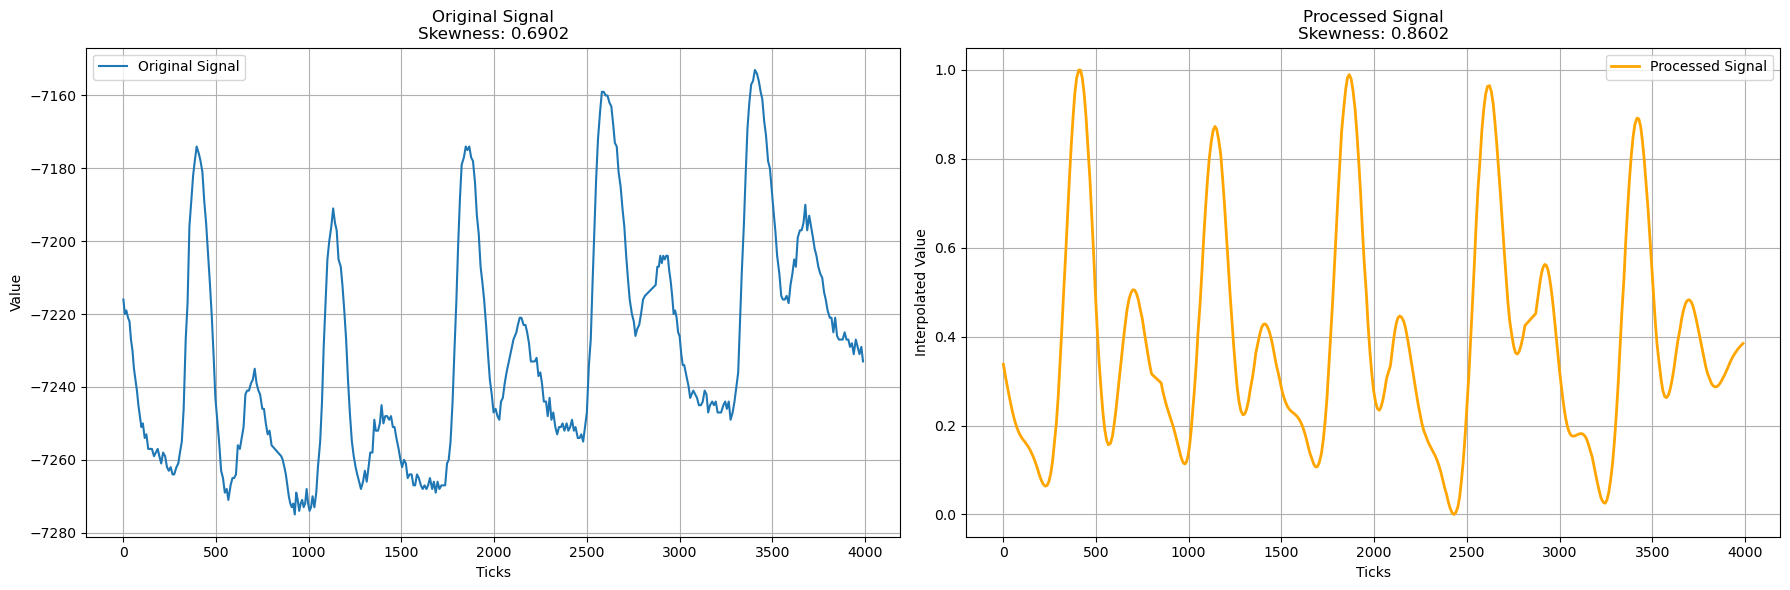

In [13]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import cheby2, filtfilt
from scipy.stats import skew

# Read the data from the CSV file
data_file = 'C:/Users/wgabr/Python Codes/SmartBP/Computing/measures_ticks.csv'
df = pd.read_csv(data_file)

# Function to process and plot a specific measure by index
def process_and_plot_measure(index):
    # Extract the datetime and values strings
    datetime = df.iloc[index, 0]
    values_string = df.iloc[index, 1].strip('"')
    ticks_string = df.iloc[index, 2].strip('"')

    # Convert the values string to a list of integers
    try:
        values = [int(v) for v in values_string.split(',') if v.strip().isdigit()]
        ticks = [int(t) for t in ticks_string.split(',') if t.strip().isdigit()]
    except ValueError as e:
        print(f"Error parsing values or ticks on row {index + 1}: {e}")
        return

    # Convert values and ticks to numpy arrays
    ppg_signal = np.array(values) * -1
    ppg_ticks = np.array(ticks)

    # Ensure the lengths of values and ticks match
    if len(ppg_signal) != len(ppg_ticks):
        print(f"Mismatch in lengths of values and ticks on row {index + 1}")
        return

    # 4th order Chebyshev-II bandpass filter
    num_values = len(ppg_signal)
    fs = num_values / 4
    lowcut = 0.5
    highcut = 8.0
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    
    b, a = cheby2(4, 40, [low, high], btype='bandpass')
    
    # Apply the filter to the PPG signal
    filtered_signal = filtfilt(b, a, ppg_signal)
    
    # Scale the filtered signal between 0 and 1
    scaled_signal = (filtered_signal - np.min(filtered_signal)) / (np.max(filtered_signal) - np.min(filtered_signal))
    
    # Prepare the data for the model
    scaled_signal = np.array(scaled_signal, dtype=np.float32)

    # Calculate skewness
    ssqi_original = skew(ppg_signal)
    ssqi_filtered = skew(scaled_signal)

    # Print skewness
    print(len(ppg_signal))
    print(f'Datetime: {datetime}')
    print(f'Skewness Signal Quality Index (SSQI) Filtered: {ssqi_filtered}')
    print(f'Skewness Signal Quality Index (SSQI) Original: {ssqi_original}')

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Original signal
    ax1.plot(ppg_ticks, ppg_signal, label='Original Signal')
    ax1.set_xlabel('Ticks')
    ax1.set_ylabel('Value')
    ax1.set_title(f'Original Signal\nSkewness: {ssqi_original:.4f}')
    ax1.legend()
    ax1.grid(True)

    # Processed Signal
    ax2.plot(ppg_ticks, scaled_signal, label='Processed Signal', linewidth=2, color='orange')
    ax2.set_xlabel('Ticks')
    ax2.set_ylabel('Interpolated Value')
    ax2.set_title(f'Processed Signal\nSkewness: {ssqi_filtered:.4f}')
    ax2.legend()
    ax2.grid(True)

    # Adjust the spacing between subplots
    plt.tight_layout()
    plt.show()

# Example usage: process and plot the measure at index 0
process_and_plot_measure(-1)